In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from massimal import hyspec_cnn
from datetime import datetime

In [3]:
# Create timestamp
timestamp = datetime.now().strftime('%Y-%m-%d-%Hh%Mm%Ss')
print(timestamp)

2024-04-30-12h57m56s


In [4]:
# Paths
train_dataset_path = Path('/home/mha114/data/massimal/vega_sola/hyperspec/datasets/pca_images/pca_images_log_rrs_v1/train_val_tiles/vega_sola_log_rrs_pca5_tiles/')
test_dataset_path = Path('/home/mha114/data/massimal/vega_sola/hyperspec/datasets/pca_images/pca_images_log_rrs_v1/test_tiles/vega_sola_log_rrs_pca5_tiles')
unet_model_save_dir = Path(f'/home/mha114/data/massimal/vega_sola/hyperspec/models/geohab_unet_log_rrs_v1/{timestamp}')
unet_model_save_dir.mkdir(exist_ok=True)


In [5]:
# Check if GPU is used
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Parameters
OUTPUT_CHANNELS = 9 # Background + 8 grouped classes 
BATCH_SIZE = 8
DEPTH = 3
#TRAIN_FRAC = 0.7
MAX_EPOCHS = 100
INITIAL_LEARNING_RATE = 0.0001#0.0001
LEARNING_RATE_FRAC_ON_PLATEAU = 0.2
LEARNING_RATE_REDUCTION_PATIENCE = 6
EARLY_STOPPING_PATIENCE = 12
FIRST_LAYER_CHANNELS = 32

In [7]:
# Load dataset 
train_dataset = tf.data.experimental.load(str(train_dataset_path))
test_dataset = tf.data.experimental.load(str(test_dataset_path))

print(f'Number of training tiles: {train_dataset.cardinality()}')
print(f'Number of validation tiles: {test_dataset.cardinality()}')

tile_nrows,tile_ncols,tile_nchannels = train_dataset.element_spec[0].shape.as_list()

Number of training tiles: 4526
Number of validation tiles: 2502


In [8]:
# Shuffle training dataset
n_train_tiles = train_dataset.cardinality()
train_dataset.shuffle(n_train_tiles)

<ShuffleDataset element_spec=(TensorSpec(shape=(128, 128, 5), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [9]:
# From https://www.tensorflow.org/tutorials/images/segmentation#optional_imbalanced_classes_and_class_weights
def add_sample_weights(image, label, name):
    class_weights = tf.constant([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]) # Hard-coded for 8 classes
    # class_weights = tf.constant([0.0, 0.89, 1.24, 0.82, 0.65, 1.08, 1.54, 0.77]) # Hard-coded for 7 classes
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [10]:
# Add sample weights
train_dataset = train_dataset.map(add_sample_weights)
test_dataset = test_dataset.map(add_sample_weights)

In [11]:
# Create the U-Net model
unet = hyspec_cnn.unet(input_channels=tile_nchannels,
                       output_channels=OUTPUT_CHANNELS,
                       first_layer_channels=FIRST_LAYER_CHANNELS,
                       depth = DEPTH,
               )
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 5)]                                                              
                                                                                                  
 augmentation (Sequential)      (None, None, None,   0           ['input_image[0][0]']            
                                5)                                                                
                                                                                                  
 initial_convolution (Conv2D)   (None, None, None,   1472        ['augmentation[0][0]']           
                                32)                                                           

In [12]:
# Print layers with sublayers
for layer in unet.layers:
    print('----')
    print(layer.name)
    if hasattr(layer,'layers'):
        for l in layer.layers:
            print('\t'+l.name)
       # print(layer.layers)

----
input_image
----
augmentation
	random_flip
----
initial_convolution
----
downsamp_res_1/2
	conv2d
	batch_normalization
	leaky_re_lu
----
downsamp_res_1/4
	conv2d_1
	batch_normalization_1
	leaky_re_lu_1
----
downsamp_res_1/8
	conv2d_2
	batch_normalization_2
	leaky_re_lu_2
----
upsamp_res_1/4
	conv2d_transpose
	batch_normalization_3
	re_lu
----
skipconnection_res_1/4
----
upsamp_res_1/2
	conv2d_transpose_1
	batch_normalization_4
	re_lu_1
----
skipconnection_res_1/2
----
upsamp_res_1/1
	conv2d_transpose_2
	batch_normalization_5
	re_lu_2
----
skipconnection_res_1/1
----
classification


In [13]:
# Define callbacks
model_save_filename = str(unet_model_save_dir) + '/unet_model.depth' + str(DEPTH) +'.epoch{epoch:02d}-loss{val_loss:.6f}-acc{val_sparse_categorical_accuracy:.3f}.hdf5'
callbacks =[tf.keras.callbacks.ModelCheckpoint(filepath = model_save_filename,
                                               save_best_only=True,
                                               verbose = 1),
            tf.keras.callbacks.ReduceLROnPlateau(factor=LEARNING_RATE_FRAC_ON_PLATEAU,
                                                 patience=LEARNING_RATE_REDUCTION_PATIENCE,
                                                 verbose=1),
            tf.keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE,
                                             min_delta = 0.001)]

In [14]:
model_save_filename

'/home/mha114/data/massimal/vega_sola/hyperspec/models/geohab_unet_log_rrs_v1/2024-04-30-12h57m56s/unet_model.depth3.epoch{epoch:02d}-loss{val_loss:.6f}-acc{val_sparse_categorical_accuracy:.3f}.hdf5'

In [15]:
# Compile model
unet.compile(optimizer=tf.keras.optimizers.RMSprop(INITIAL_LEARNING_RATE), 
             loss="sparse_categorical_crossentropy",
             weighted_metrics=['sparse_categorical_accuracy'], # Need weights to ignore background
             metrics = []) # Sparse because classes are numbered, not one-hot

In [16]:
# Fit model to dataset
history = unet.fit(train_dataset.batch(BATCH_SIZE),
                   epochs=MAX_EPOCHS,
                   validation_data=test_dataset.batch(BATCH_SIZE),
                   callbacks=callbacks)
# history = unet.fit(train_dataset.batch(BATCH_SIZE),
#                    epochs=MAX_EPOCHS)

Epoch 1/100
566/566 [==============================] - ETA: 0s - loss: 0.0928 - sparse_categorical_accuracy: 0.5749
Epoch 1: val_loss improved from inf to 0.10531, saving model to /home/mha114/data/massimal/vega_sola/hyperspec/models/geohab_unet_log_rrs_v1/2024-04-30-12h57m56s/unet_model.depth3.epoch01-loss0.105307-acc0.452.hdf5
566/566 [==============================] - 14s 21ms/step - loss: 0.0928 - sparse_categorical_accuracy: 0.5749 - val_loss: 0.1053 - val_sparse_categorical_accuracy: 0.4521 - lr: 1.0000e-04
Epoch 2/100
565/566 [============================>.] - ETA: 0s - loss: 0.0824 - sparse_categorical_accuracy: 0.6212
Epoch 2: val_loss improved from 0.10531 to 0.09782, saving model to /home/mha114/data/massimal/vega_sola/hyperspec/models/geohab_unet_log_rrs_v1/2024-04-30-12h57m56s/unet_model.depth3.epoch02-loss0.097824-acc0.519.hdf5
566/566 [==============================] - 12s 21ms/step - loss: 0.0823 - sparse_categorical_accuracy: 0.6211 - val_loss: 0.0978 - val_sparse_cate

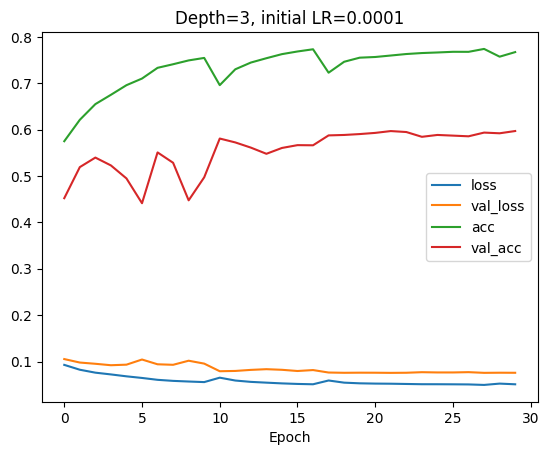

In [17]:
# Plot training history
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.plot(history.history['sparse_categorical_accuracy'],label='acc')
plt.plot(history.history['val_sparse_categorical_accuracy'],label='val_acc')
plt.xlabel('Epoch')
plt.title(f'Depth={DEPTH}, initial LR={INITIAL_LEARNING_RATE}')
plt.legend()
plt.savefig(unet_model_save_dir / 'unet_training_history.png')
plt.show()